# 0. Überblick und Setup
In diesem Notebook gehen wir auf das Vorlesungskapitel 2 mit den Inhalten **Lage + Streuung + Verteilungsform** ein.

In [8]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent          # eine Ebene über notebooks/
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os
from src.utils_stats import iqr, mad, trimmed_mean, fd_bins, tukey_fences, modified_z_scores, ecdf
from src.utils_plots import hist_kde, box_violin, plot_ecdf, hist_with_fences, plot_qq


PATH = "../data/Taxi_final_1M.csv"
df = pd.read_csv(PATH)

print(80*"=")
print(f"Datensatz geladen: {df.shape[0]:,} Zeilen, {df.shape[1]} Spalten")
print(80*"-")
print("Erste Zeilen:", "\n", df.head(3))
print(80*"-")
print(df.describe())
print(80*"-")
print(df.info())
print(80*"=")

Datensatz geladen: 999,997 Zeilen, 17 Spalten
--------------------------------------------------------------------------------
Erste Zeilen: 
   tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2023-02-06 18:31:28   2023-02-06 18:41:28              1.0            2.8   
1  2023-01-13 12:22:41   2023-01-13 12:54:42              1.0            0.0   
2  2023-01-24 12:53:51   2023-01-24 13:06:09              5.0            2.3   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  tip_amount  \
0           162           113             1         11.4    2.5         2.0   
1            76            61             1         22.0    0.0         0.0   
2           142            48             2         12.1    0.0         0.0   

   tolls_amount  improvement_surcharge  total_amount  congestion_surcharge  \
0           0.0                    1.0          19.9                   2.5   
1           0.0                    1.0          23.5           

# 1. Lagekennzahlen

In [ ]:
vars_num = ["trip_distance","trip_duration","average_speed","fare_amount","tip_amount","total_amount"]

def location_row(s):
    s = s.dropna()
    return pd.Series({
        "n": s.size,
        "Median": s.median(),
        "Mean": s.mean(),
        "TrimmedMean(10%)": trimmed_mean(s, 0.10)
    })

location_summary = pd.concat([location_row(df[v]).rename(v) for v in vars_num], axis=1).T
display(location_summary.style.format("{:,.2f}"))

# 2. Streuungskennzahlen

In [ ]:
def spread_summary(s):
    s = s.dropna()
    q1, q3 = s.quantile([.25, .75])
    IQR = q3 - q1
    MAD = (s - s.median()).abs().median()
    return pd.Series({
        "IQR": IQR,
        "MAD": MAD,
        "Var": np.var(s, ddof=1),
        "SD": np.std(s, ddof=1)
    })

spread_tbl = pd.concat([spread_summary(df[v]).rename(v) for v in vars_num], axis=1).T
display(spread_tbl)

# 3. Ausreißer erkennen (Diagnose)

In [ ]:
def tukey_fences(s, k=1.5):
    s = s.dropna()
    q1, q3 = s.quantile([.25,.75])
    I = q3 - q1
    return q1 - k * I, q3 + k * I

def modified_z(s):
    s = s.dropna()
    MAD = (s - s.median()).abs().median()
    if MAD == 0: return pd.Series(0.0, index=s.index)
    return 0.6745 * (s - s.median()) / MAD

rows = []
for v in vars_num:
    s = df[v].dropna()
    lo, hi = tukey_fences(s, 1.5)
    tukey_mask = (s < lo) | (s > hi)
    mz = modified_z(s).abs() > 3.5

    # Flags im DF (für Kap. 4)
    df[f"{v}__out_tukey"] = False
    df.loc[s.index, f"{v}__out_tukey"] = tukey_mask
    df[f"{v}__out_modz"]  = False
    df.loc[s.index, f"{v}__out_modz"]  = mz

    rows.append([v, s.size, int(tukey_mask.sum()), int(mz.sum()), lo, hi])

outlier_df = pd.DataFrame(rows, columns=["var","n","Tukey_1.5IQR","modZ>|3.5|","lo","hi"])
display(outlier_df.style.format({"lo":"{:.2f}","hi":"{:.2f}"}))

# 4. Verteilungsform (Histogramm + KDE)

KeyboardInterrupt: 

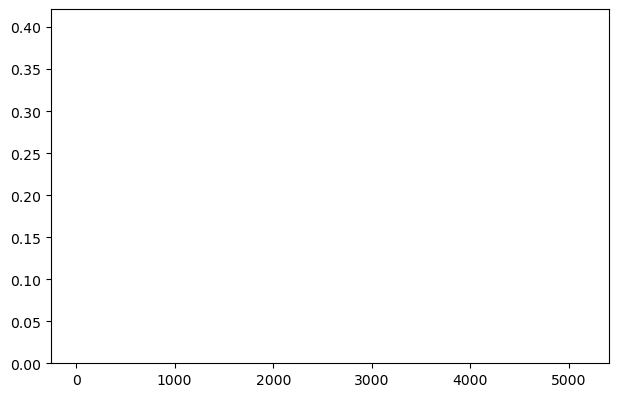

In [9]:
for v,u in [("trip_distance","miles"),
            ("trip_duration","min"),
            ("average_speed","mph"),
            ("fare_amount","USD"),
            ("tip_amount","USD"),
            ("total_amount","USD")]:
    hist_kde(df[v], title=v, unit=u, bw_adjust_list=(0.7, 1.0, 1.8))
    box_violin(df[v], title=v)
    plot_ecdf(df[v], title=v, unit=u)